In [95]:
import os
import torch
import pandas as pd 
from torchaudio import info,load
from librosa import get_samplerate,get_duration
import numpy as np
from torchaudio.transforms import Resample,MelSpectrogram

In [8]:

## list with all the files 
pathtowav = '/media/nfarrugi/Expansion/EcoHack/Chunks/'
chunklist = os.listdir(pathtowav)

In [9]:
goodfiles = []

for curfile in chunklist:
    splitted = curfile.split('_')
    
    if (os.path.splitext(curfile)[1] == '.wav') and (splitted[-2]!='3s'):
        goodfiles.append(curfile)

In [10]:
labelsfile = '20221101_120529UTC_summary.txt'

In [11]:
wav,sr = load(os.path.join(pathtowav,goodfiles[0]))

In [12]:
print(f"Duration of file {goodfiles[0]} is {wav.shape[1] / sr} seconds")

Duration of file 20210418_184500.loc01_00;33-00;36_(type_1).wav is 3.0 seconds


In [13]:
len(goodfiles)

5190

In [14]:
Df = pd.read_csv(os.path.join(pathtowav,labelsfile),names=['origpath','call1','call2','call3','call4'])

In [15]:
Df['wav'] = [curpath[49:] for curpath in Df['origpath']]

In [17]:
Df[Df['wav'] == curfile]['call1']

Series([], Name: call1, dtype: int64)

In [18]:
(Df[Df['wav'] == curfile]['call1'])

Series([], Name: call1, dtype: int64)

In [19]:
recorders = [curstring.split('loc') for curstring in Df['wav']]

loc01 -> recorder 1

loc1 ->recorder 1 

loc4B -> recorder 2 

loc8B -> recorder 3 

loc10 -> recorder 4 

AM02 -> recorder 5

In [123]:
rec_dict ={'01':1,'1_':1,'4B':2,'8B':3,'10':4,'30':5,'CG010':6,'CG004':7,'CG001':8,'XC':9,'ID':10,'AM':11}

In [126]:
currec[0][:2]

'XC'

In [132]:
rec_id = []
for currec in recorders:
    if len(currec)==1:
        
        if currec[0][:2]=='AM':
            rec_id.append(rec_dict['AM'])
        elif currec[0][:2]=='ID':
            rec_id.append(rec_dict['ID'])
        elif currec[0][:2]=='XC':
            rec_id.append(rec_dict['XC'])
        elif currec[0][:5]=='CG010':
            rec_id.append(rec_dict['CG010'])
        elif currec[0][:5]=='CG004':
            rec_id.append(rec_dict['CG004'])
        elif currec[0][:5]=='CG001':
            rec_id.append(rec_dict['CG001'])
        else:
            print(currec[0][:4])
    else:
        rec_id.append(rec_dict[currec[1][:2]])
    

In [133]:
Df['recorder_id']=rec_id

In [134]:
np.unique(rec_id,return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 920,  247,  133,  112,   13, 1268,  290, 1014,  665,  136,  340]))

Long cell
--

In [147]:
allsamplerates = []
waves_32k = []
labels = []
recorders_id = []
for curfile in goodfiles:
    meta = info((os.path.join(pathtowav,curfile)))
    sr = meta.sample_rate
    resamp = Resample(orig_freq=sr,new_freq=8000)
    
    curwave = resamp(load(os.path.join(pathtowav,curfile))[0])
    
    if curwave.shape[1]==3*8000 and len(Df[Df['wav'] == curfile])!=0 :
        waves_32k.append(curwave)
        recorders_id.append(Df[Df['wav'] == curfile]['recorder_id'].iloc[0])
        if (Df[Df['wav'] == curfile]['call1'].iloc[0])==1:
            labels.append(1)
        elif (Df[Df['wav'] == curfile]['call2'].iloc[0])==1:
            labels.append(2)
        elif (Df[Df['wav'] == curfile]['call3'].iloc[0])==1:
            labels.append(3)
        elif (Df[Df['wav'] == curfile]['call4'].iloc[0])==1:
            labels.append(4)
            
waves_32k = torch.vstack(waves_32k)

In [148]:
torch.save(waves_32k,'/media/nfarrugi/Expansion/EcoHack/allwaves.pth')
torch.save(labels,'/media/nfarrugi/Expansion/EcoHack/labels.pth')
torch.save(recorders_id,'/media/nfarrugi/Expansion/EcoHack/recorders.pth')

In [149]:
waves_32k = torch.load('/media/nfarrugi/Expansion/EcoHack/allwaves.pth')
labels = torch.load('/media/nfarrugi/Expansion/EcoHack/labels.pth')
recorders_id = torch.load('/media/nfarrugi/Expansion/EcoHack/recorders.pth')

In [151]:
print(waves_32k.shape,len(labels),len(recorders_id))

torch.Size([5135, 24000]) 5135 5135


Spectrogram estimation

In [65]:
mel = MelSpectrogram(sample_rate=8000,n_fft=200,hop_length=200,n_mels=64)

In [66]:
mels= mel(waves_32k)

In [67]:
mels.shape

torch.Size([5135, 64, 121])

In [68]:
64*121

7744

In [94]:
np.unique(labels,return_counts=True)

NameError: name 'np' is not defined

In [41]:
from sklearn.model_selection import train_test_split

In [260]:
np.unique(recorders_id,return_counts=True)

(array([1, 2, 3, 4, 5, 6]), array([920, 247, 133, 111,  13, 340]))

Naive test with 80/20 train test split, regardless of recording sites 

In [114]:
x_train,x_test,y_train,y_test = train_test_split(mels.reshape(5135,-1).detach().numpy(),labels,train_size=0.8)

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

In [83]:
clf = OneVsRestClassifier(RandomForestClassifier())

In [84]:
clf.fit(x_train,y_train)

OneVsRestClassifier(estimator=RandomForestClassifier())

In [85]:
y_pred_train = clf.predict(x_train)

In [86]:
y_pred = clf.predict(x_test)

In [87]:
from sklearn.metrics import classification_report

In [88]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1020
           2       1.00      1.00      1.00      1773
           3       1.00      1.00      1.00       717
           4       1.00      0.99      1.00       598

    accuracy                           1.00      4108
   macro avg       1.00      1.00      1.00      4108
weighted avg       1.00      1.00      1.00      4108



In [89]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.64      0.76      0.69       255
           2       0.70      0.83      0.76       449
           3       0.77      0.80      0.78       172
           4       1.00      0.05      0.10       151

    accuracy                           0.69      1027
   macro avg       0.78      0.61      0.58      1027
weighted avg       0.74      0.69      0.65      1027



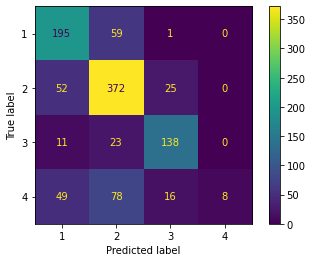

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

Leave one site out
--

In [143]:
from sklearn.model_selection import LeaveOneGroupOut,cross_val_score
from sklearn.linear_model import LogisticRegression

In [139]:
logo = LeaveOneGroupOut()

In [153]:
clf = OneVsRestClassifier(RandomForestClassifier())

score = cross_val_score(clf,X=mels.reshape(5135,-1).detach().numpy(),y=labels,groups=recorders_id,cv=logo)

In [155]:
score,rec_dict

(array([0.62934783, 0.58299595, 0.61654135, 0.62162162, 0.61538462,
        0.54581359, 0.39310345, 0.77712032, 0.18345865, 0.38970588,
        0.69117647]),
 {'01': 1,
  '1_': 1,
  '4B': 2,
  '8B': 3,
  '10': 4,
  '30': 5,
  'CG010': 6,
  'CG004': 7,
  'CG001': 8,
  'XC': 9,
  'ID': 10,
  'AM': 11})

In [159]:
np.unique(recorders_id,return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 920,  247,  133,  111,   13, 1266,  290, 1014,  665,  136,  340]))

Tests with TPOT

In [115]:
from tpot import TPOTClassifier

In [116]:
pipeline_optimizer = TPOTClassifier(generations=3, population_size=5, cv=5,
                                    random_state=42, verbosity=2)

pipeline_optimizer.fit(x_train, y_train)

Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5708375934635526

Generation 2 - Current best internal CV score: 0.5708375934635526

Generation 3 - Current best internal CV score: 0.5971191147227136

Best pipeline: GaussianNB(Normalizer(input_matrix, norm=l2))


AttributeError: 'list' object has no attribute 'astype'

In [118]:

print(pipeline_optimizer.score(x_test, np.array(y_test)))

0.6037000973709834


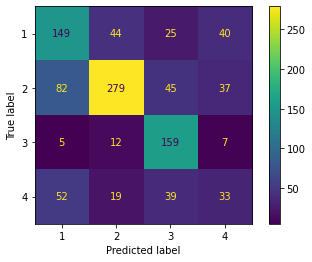

In [120]:
y_pred = pipeline_optimizer.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [121]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.52      0.58      0.55       258
           2       0.79      0.63      0.70       443
           3       0.59      0.87      0.71       183
           4       0.28      0.23      0.25       143

    accuracy                           0.60      1027
   macro avg       0.55      0.58      0.55      1027
weighted avg       0.61      0.60      0.60      1027

